# pvlib-Python Forecasting (Albuquerque, NM)
### Install Standard Release 

In [1]:
# pip Upgrade
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 3.3MB/s eta 0:00:01     |████████▍                       | 389kB 3.3MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

     |████████████████████████████████| 20.4 MB 5.4 kB/s eta 0:00:011   |████████████▉                   | 8.2 MB 6.4 MB/s eta 0:00:02
     |████████████████████████████████| 4.1 MB 906 kB/s eta 0:00:01     |██████████████████████████      | 3.3 MB 906 kB/s eta 0:00:01
     |████████████████████████████████| 322 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 217 kB/s eta 0:00:01
     |████████████████████████████████| 320 kB 1.6 MB/s eta 0:00:01
  Attempting uninstall: cftime
    Found existing installation: cftime 1.1.3
    Uninstalling cftime-1.1.3:
      Successfully uninstalled cftime-1.1.3


In [3]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=1)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


### Create Model

In [4]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average  \
2020-06-16 06:00:00-06:00                                               73.0             
2020-06-16 09:00:00-06:00                                              100.0             
2020-06-16 12:00:00-06:00                                               95.0             
2020-06-16 15:00:00-06:00                                               13.0             
2020-06-16 18:00:00-06:00                                                6.0             

                           Wind_speed_gust_surface  \
2020-06-16 06:00:00-06:00                 6.726562   
2020-06-16 09:00:00-06:00                 6.329565   
2020-06-16 12:00:00-06:00                 3.206659   
2020-06-16 15:00:00-06:00                 5.800990   
2020-06-16 18:00:00-06:00                 6.914482   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-06-16 06:00:00-06:00                

### Process Data with pvlib

In [5]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-06-16 06:00:00-06:00  18.891510    4.808540    0.257303    0.000000   
2020-06-16 09:00:00-06:00  17.588470    4.255585  184.420814    6.354409   
2020-06-16 12:00:00-06:00  15.859772    2.803926  358.937993   21.371571   
2020-06-16 15:00:00-06:00  29.550018    4.815103  799.955262  520.286769   
2020-06-16 18:00:00-06:00  39.134491    7.495283  359.930075  542.776081   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-06-16 06:00:00-06:00    0.257303          73.0         0.0         1.0   
2020-06-16 09:00:00-06:00  180.717927         100.0         0.0         5.0   
2020-06-16 12:00:00-06:00  338.692006          95.0         0.0         2.0   
2020-06-16 15:00:00-06:00  336.692125          13.0         0.0         0.0   
2020-06-16 18:00:00-06:00  118.224079           6.0         0.0         0.0   

                           high_clouds  
2020-06-16 06:00:00-06:00  

### GFS'S Class

In [6]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-06-16 06:00:00-06:00  18.891510    4.808540    0.257303    0.000000   
2020-06-16 09:00:00-06:00  17.588470    4.255585  184.420814    6.354409   
2020-06-16 12:00:00-06:00  15.859772    2.803926  358.937993   21.371571   
2020-06-16 15:00:00-06:00  29.550018    4.815103  799.955262  520.286769   
2020-06-16 18:00:00-06:00  39.134491    7.495283  359.930075  542.776081   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-06-16 06:00:00-06:00    0.257303          73.0         0.0         1.0   
2020-06-16 09:00:00-06:00  180.717927         100.0         0.0         5.0   
2020-06-16 12:00:00-06:00  338.692006          95.0         0.0         2.0   
2020-06-16 15:00:00-06:00  336.692125          13.0         0.0         0.0   
2020-06-16 18:00:00-06:00  118.224079           6.0         0.0         0.0   

                           high_clouds  
2020-06-16 06:00:00-06:00  

## Cloud Cover & Radiation

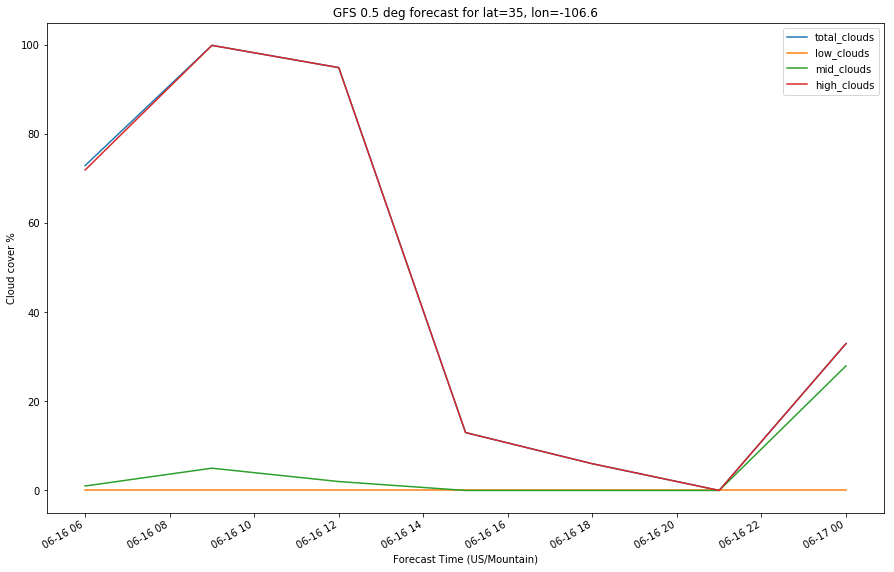

In [7]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

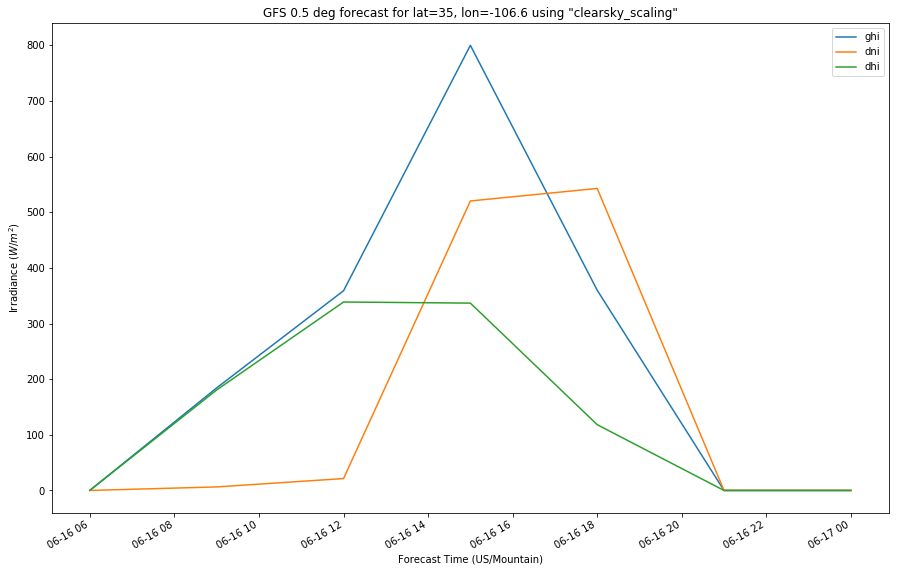

In [8]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

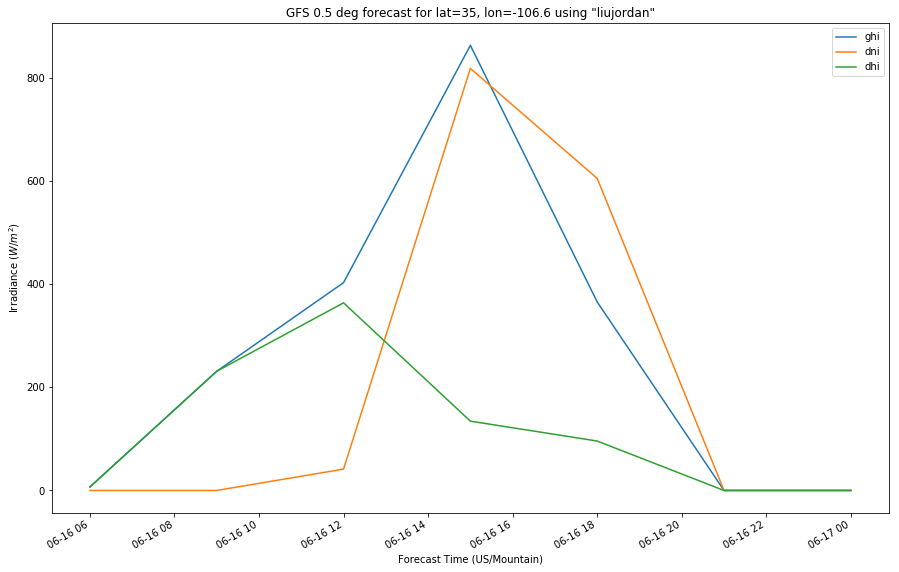

In [9]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

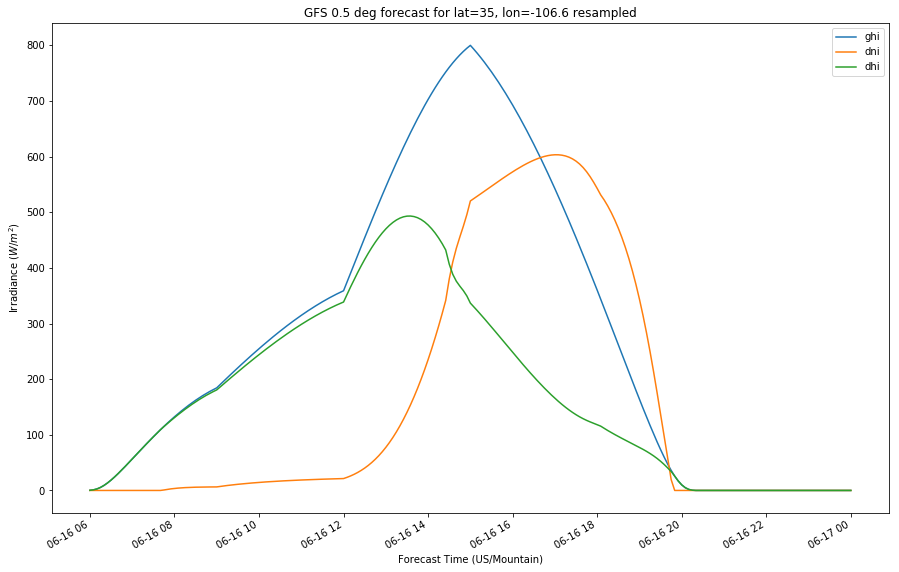

In [10]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

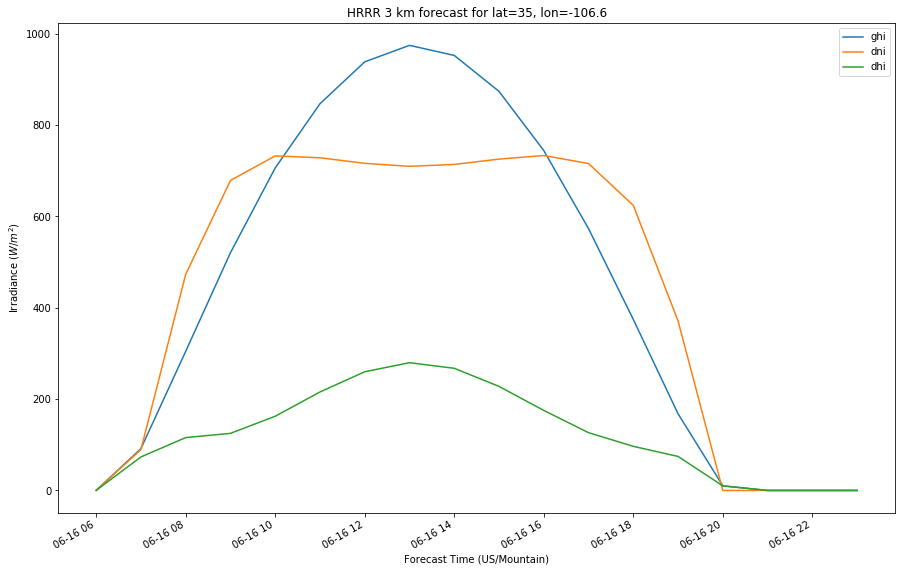

In [11]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

In [12]:
hrrr_data=data[irrad_vars]

### RAP

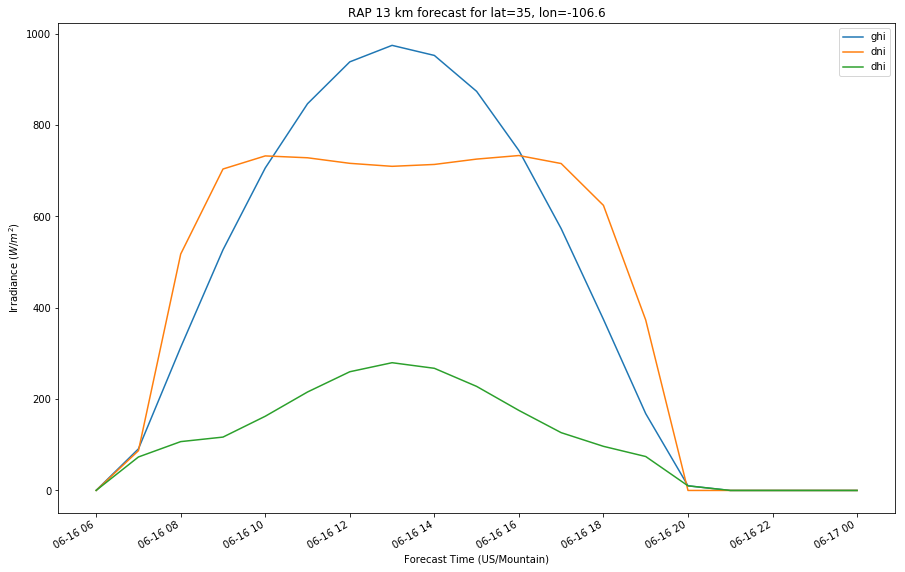

In [13]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

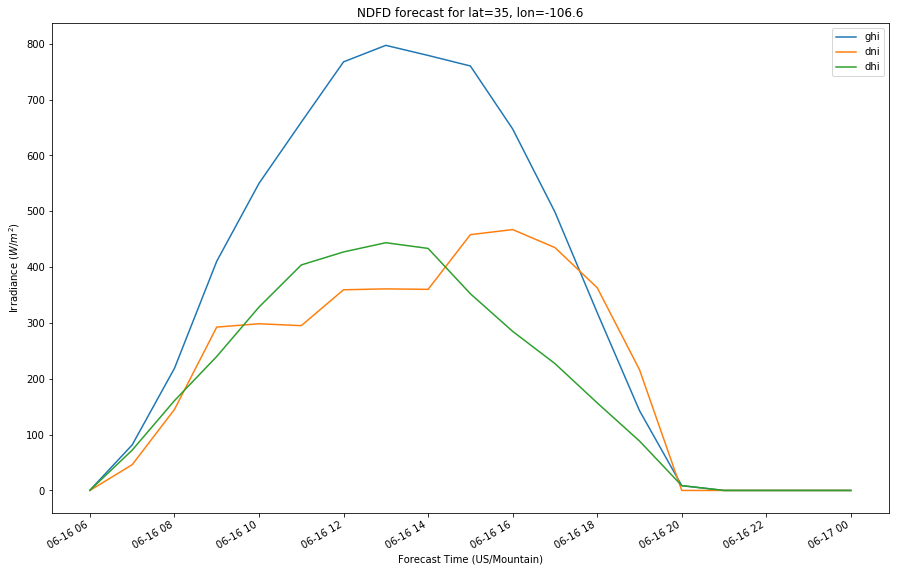

In [14]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

# PV Power Forecast

In [15]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain
from pvlib import pvsystem

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['iPower__SHO_5_2__240V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=1)

# fx is a common abbreviation for forecast
fx_model = HRRR()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [16]:
invdb = pvsystem.retrieve_sam('CECInverter')
invdb

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.08961,2.24041,1.84651,1.95054,1.76944,1.84378,46.8638,67.7909,62.5547,18.1663,...,36.0334,2.5301,22.0954,24.4658,42.7765,31.682,64.7742,54.5701,85.1457,62.4867
Paco,250,250,300,300,300,300,10000,10000,12000,3000,...,3180,230,1100,2000,2500,3000,3500,4600,4800,5200
Pdco,259.589,259.492,311.669,311.581,312.421,312.005,10488.3,10296,12358.8,3142.3,...,3315.65,245.63,1194.09,2161.88,2632.84,3205.93,3641.84,4797.81,4968.03,5382.86
Vdco,40,40,40,40,45,45,320,362,370,310,...,375,40,182,199,218,222.5,263,254,263,280
C0,-4.1e-05,-3.9e-05,-3.3e-05,-3.4e-05,-4.5e-05,-3.5e-05,-2.7759e-06,-1.38839e-06,-1.009e-06,-8.03949e-06,...,-7.98467e-06,6.2e-05,-2.1e-05,-1.3e-05,-1.4e-05,-8.21046e-06,-9.08073e-06,-5.99928e-06,-6.16035e-06,-4.63524e-06
C1,-9.1e-05,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-3.6e-05,-4.9e-05,-5.6e-05,-1.1e-05,...,-7.5e-05,-9.8e-05,5.7e-05,5.5e-05,6.1e-05,3.6e-05,3.5e-05,2.8e-05,3.4e-05,4.4e-05
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


## ModelChain Attributes

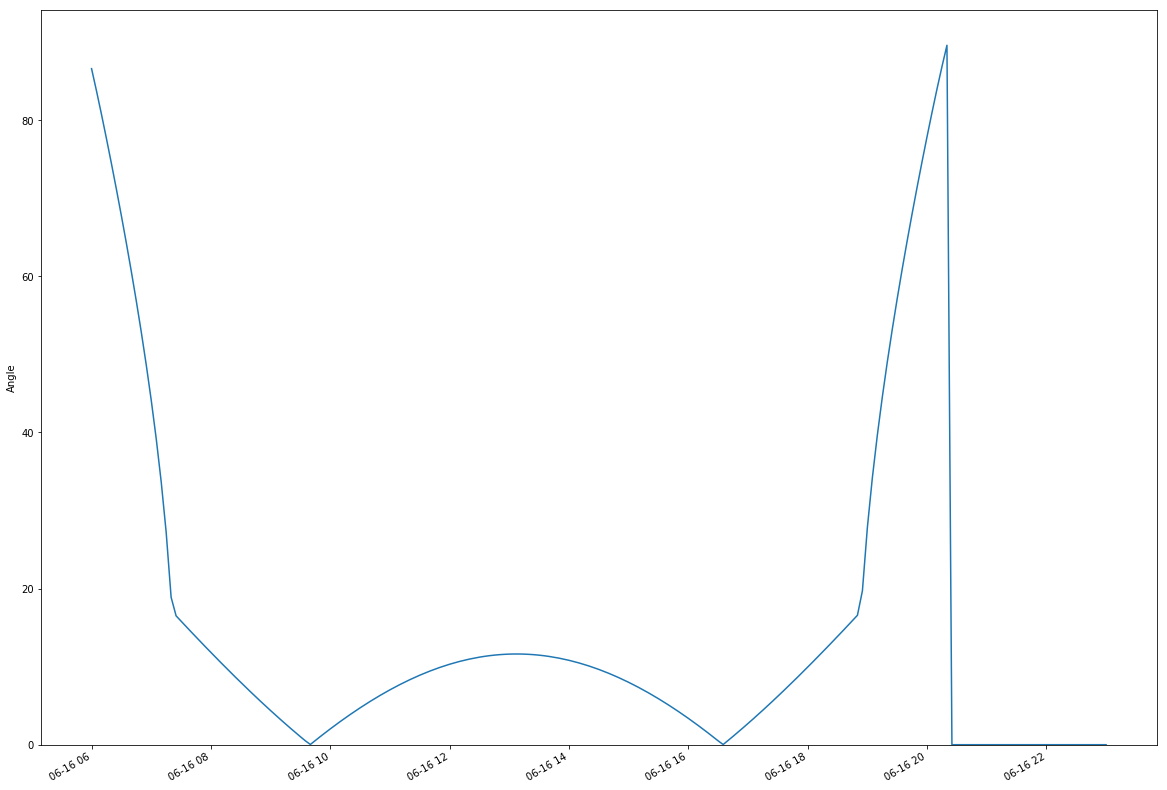

In [17]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

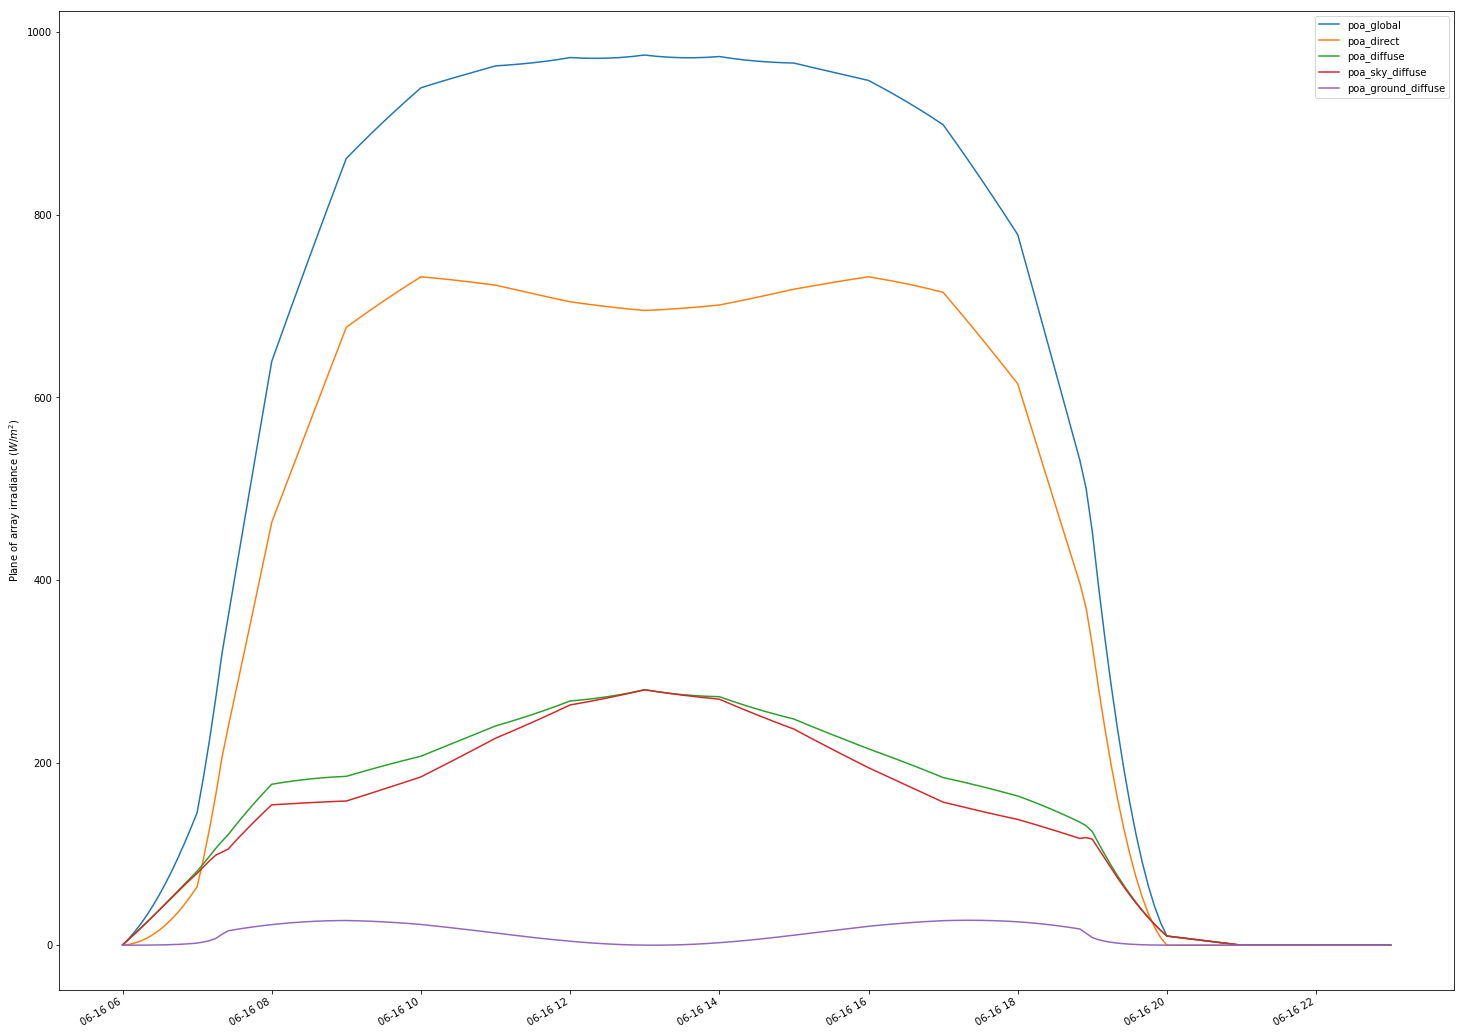

In [18]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

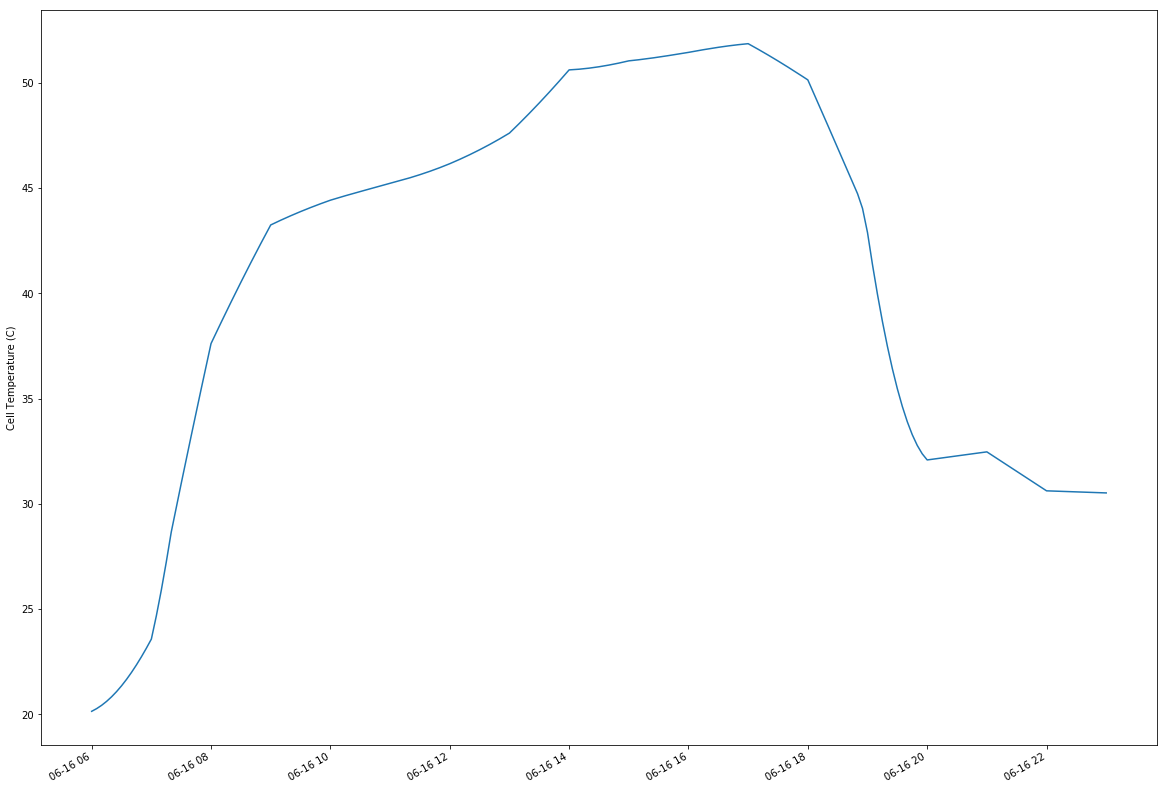

In [19]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

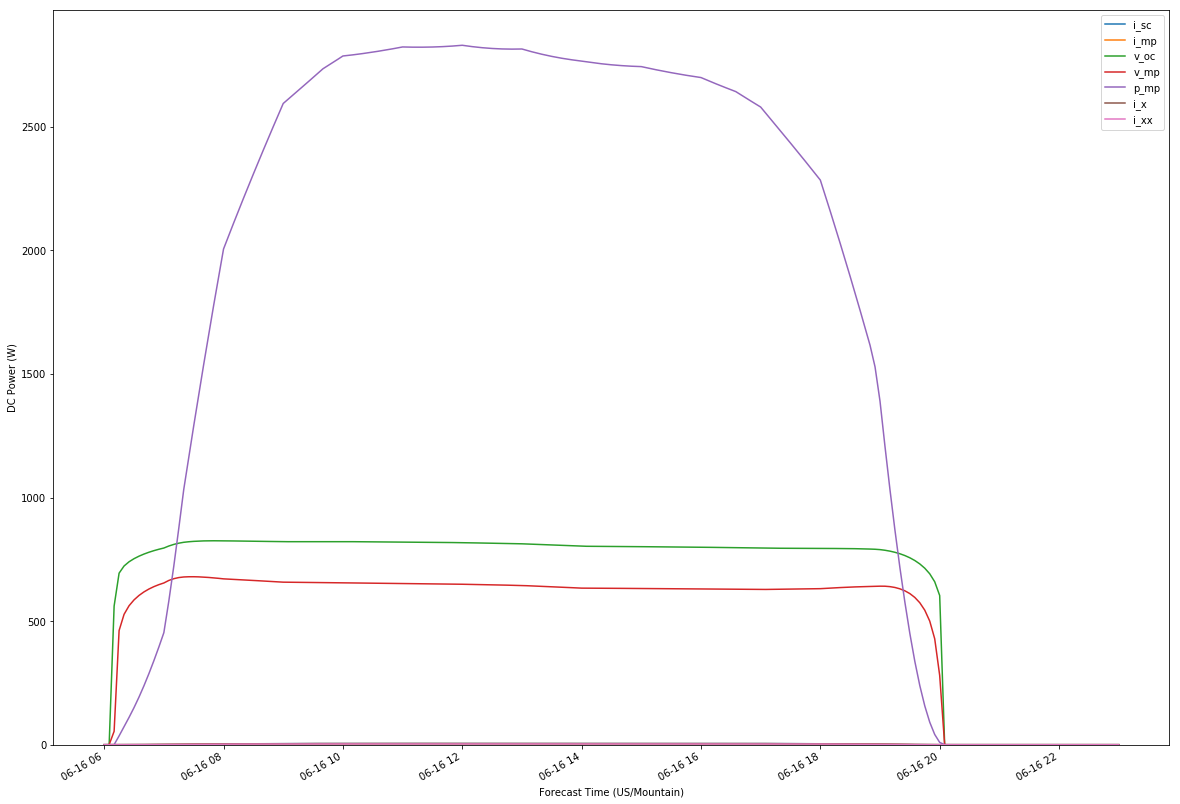

In [20]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [21]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,3.710498,3.303640,771.744609,610.595845,2125.550091,3.624847,2.371653
std,1.662191,1.475326,150.704889,130.984396,947.579239,1.624836,1.034640
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.076349,2.748935,794.266592,630.379570,1776.095353,3.002481,2.046291
50%,4.663830,4.145815,802.654657,639.192858,2650.499875,4.556820,2.962895
75%,4.874672,4.335986,820.124684,653.433597,2781.254290,4.763557,3.076318
max,4.915057,4.370221,825.170476,679.644044,2830.134671,4.803143,3.098397


In [22]:
mc.dc.fillna(0).to_csv('DC June 17.csv', encoding='utf-8')

## MC AC Power

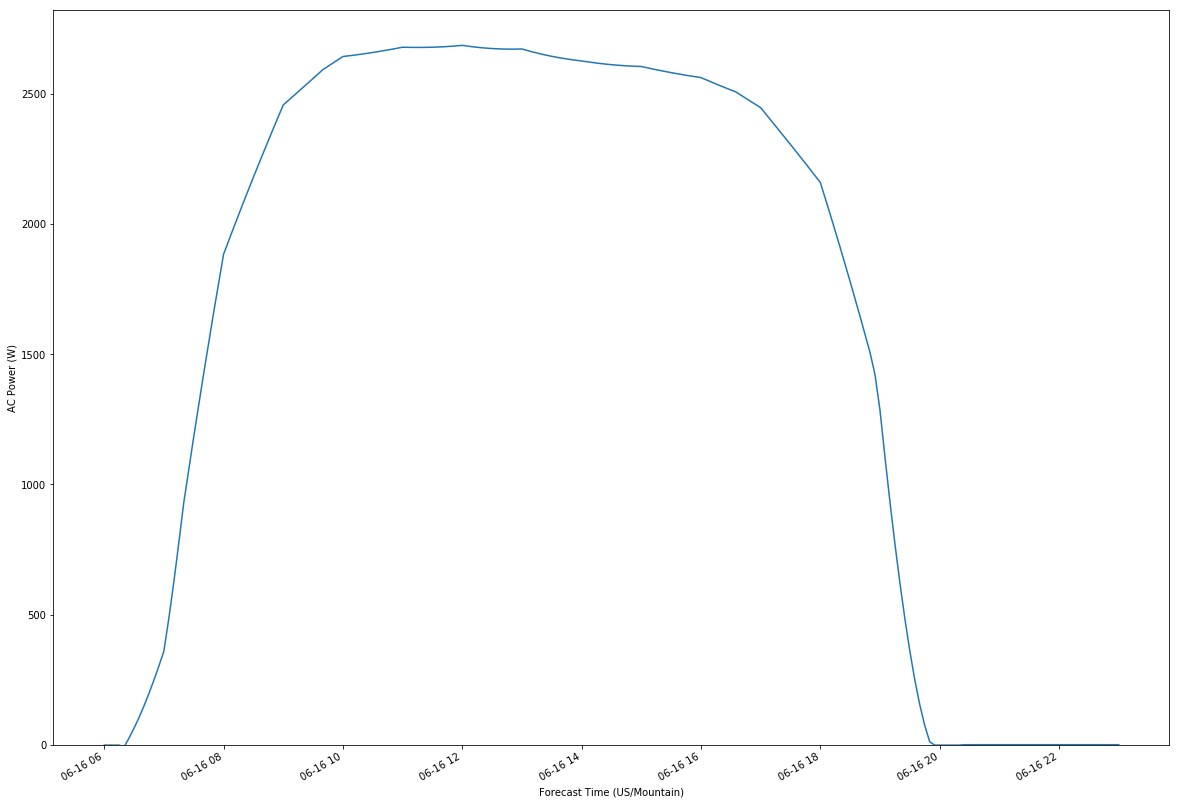

In [23]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [24]:
mc.ac.describe()

count     173.000000
mean     2003.068145
std       917.889455
min        -8.924599
25%      1658.394324
50%      2514.594988
75%      2639.910654
max      2685.620084
dtype: float64

In [25]:
mc.ac.fillna(0)

2020-06-16 06:00:00-06:00      -1.560000
2020-06-16 06:05:00-06:00      -1.560000
2020-06-16 06:10:00-06:00      -1.560000
2020-06-16 06:15:00-06:00      -1.560000
2020-06-16 06:20:00-06:00      -8.924599
2020-06-16 06:25:00-06:00      25.683962
2020-06-16 06:30:00-06:00      63.172642
2020-06-16 06:35:00-06:00     104.141762
2020-06-16 06:40:00-06:00     148.718384
2020-06-16 06:45:00-06:00     196.748851
2020-06-16 06:50:00-06:00     247.970742
2020-06-16 06:55:00-06:00     302.099806
2020-06-16 07:00:00-06:00     358.838666
2020-06-16 07:05:00-06:00     484.885705
2020-06-16 07:10:00-06:00     623.980319
2020-06-16 07:15:00-06:00     774.117235
2020-06-16 07:20:00-06:00     929.042613
2020-06-16 07:25:00-06:00    1056.529466
2020-06-16 07:30:00-06:00    1181.528926
2020-06-16 07:35:00-06:00    1304.228708
2020-06-16 07:40:00-06:00    1424.607359
2020-06-16 07:45:00-06:00    1542.660007
2020-06-16 07:50:00-06:00    1658.394324
2020-06-16 07:55:00-06:00    1771.827598
2020-06-16 08:00

In [26]:
mc.ac.fillna(0).to_csv('AC June 17.csv', encoding='utf-8')

### HRRR Irradiance Data

In [27]:
hrrr_data

,ghi,dni,dhi
2020-06-16 06:00:00-06:00,0.188081,0.000000,0.188081
2020-06-16 07:00:00-06:00,91.527380,89.408482,73.306849
2020-06-16 08:00:00-06:00,304.556343,473.105048,115.738019
2020-06-16 09:00:00-06:00,520.494835,678.720902,124.985683
2020-06-16 10:00:00-06:00,706.041614,732.441908,162.460858
2020-06-16 11:00:00-06:00,846.704155,728.358697,215.575682
2020-06-16 12:00:00-06:00,938.400000,716.211599,259.909366
2020-06-16 13:00:00-06:00,974.504283,709.647114,279.676357
2020-06-16 14:00:00-06:00,952.443413,713.771693,267.437988
2020-06-16 15:00:00-06:00,873.790635,725.480206,227.823342


In [28]:
hrrr_data.to_csv('HRRR June 17.csv', encoding='utf-8')